# 1 Camera calibration


The distortion caused by the camera lens distorts the photos and is troublesome for 3D reconstruction. So we have to correct them before doing the 3D recostruction. Before making any corrections, we need to know the internal settings of the camera we are using. OpenCV offers calibration algorithms capable of determining these parameters.
The camera calibration operation amounts to modeling the process of image formation, i.e. finding the relation between the spatial coordinates of a point in space with the associated point in the image taken by the camera.


In this tutorial, you need Python 3.7, OpenCV 3.4.2.17, Numpy and Pillow.

In [ ]:
import cv2
import numpy as np 
from glob import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

SIFT detector is also needed later, then intall the opencv 3.4.2 version

In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 138kB/s 
     |████████████████████████████████| 14.5MB 318kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:


The process of calibrating a camera in OpenCV consists in making the computer scan a picture with a chessboard pattern and identify the internal corners several times with different pictures.

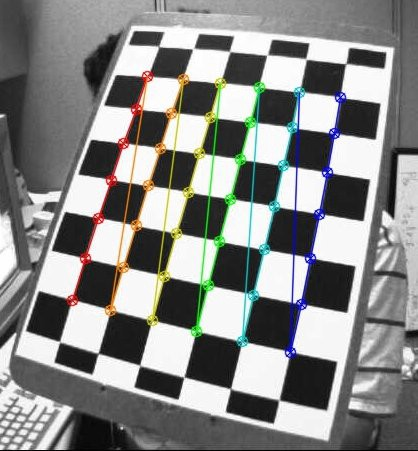

Go to this [link](https://docs.opencv.org/2.4/_downloads/pattern.png) and print this chessboard pattern on a piece of paper. Glue the chessboard to a flat and solid object. 
The first step will be to read Images of a chess board. It’s recommended to use at least 20 images to get a reliable calibration, For this, Take at least 20 images by your camera you want to calibrate. They should be in different angles and distances because the calibration code needs various points with different perspectives. 

You can download images for camera calibration here:

In [ ]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess 
    subprocess.call('apt-get install subversion'.split())
    subprocess.call('svn export https://github.com/kinect59/3DET20/trunk/Data/leftFixedStereo'.split())
    subprocess.call('svn export https://github.com/kinect59/3DET20/trunk/Data/bothImagesFixedStereo'.split())


In [ ]:
square_size=2.5

img_mask='./leftFixedStereo/left*.png'
pattern_size = (9, 6)

figsize = (20,20)

In [ ]:
img_names = glob(img_mask)
num_images = len(img_names)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = cv2.imread(img_names[0]).shape[:2]

## Step 1: find all corners in calibration plane:
Open CV helps to automatically detect the corners and draw on it by findChessboardCorners() and drawChessboardCorners() Applying both functions to a sample image, results: 
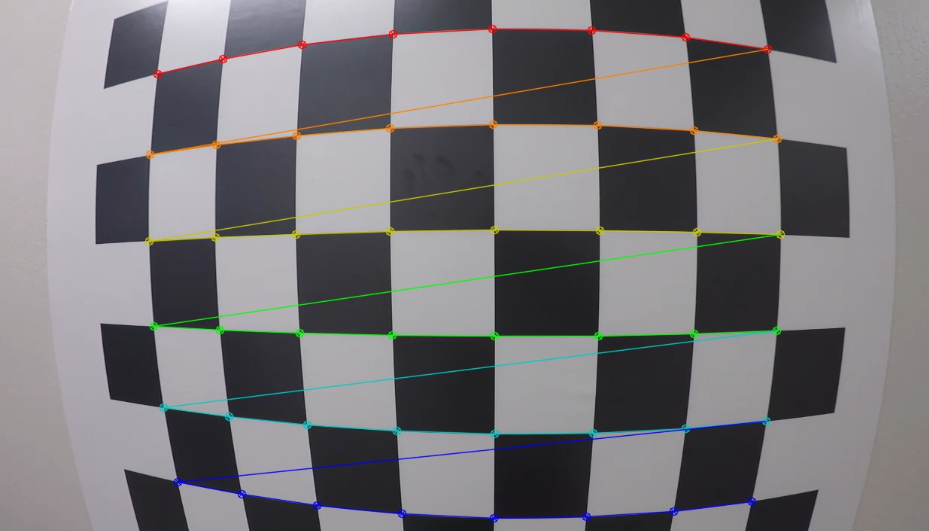


In [ ]:
plt.figure(figsize=figsize)

for i,fn in enumerate(img_names):
    print('processing %s... ' % fn)
    imgBGR = cv2.imread(fn)

    if imgBGR is None:
        print("Failed to load", fn)
        continue

    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(imgRGB,cv2.COLOR_RGB2GRAY)
    print("Image loaded, Analizying...")

    assert w == img.shape[1] and h == img.shape[0], ("size: %d x %d ... " % (img.shape[1], img.shape[0]))
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    # if you want to better improve the accuracy... cv2.findChessboardCorners already uses cv2.cornerSubPix 
    if found:
      term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
      cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    if not found:
        print('chessboard not found')
        continue

    if i<12:
        img_w_corners = cv2.drawChessboardCorners(imgRGB, pattern_size, corners, found)
        plt.subplot(4,3,i+1)
        plt.imshow(img_w_corners)



    print('           %s... OK' % fn)
    img_points.append(corners.reshape(-1, 2))
    obj_points.append(pattern_points)


plt.show()



Output hidden; open in https://colab.research.google.com to view.

## Step 2: get camera intrinsics + distortion coeffs 
We can finally proceed with the calibration of our camera and correction of our images. In order to do this we will use the function cv2.calibrateCamera(). It returns the camera matrix and distortion coefficients including rotation and translation vectors for our extrinsic values.


In [ ]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms) # Root mean square error
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())




RMS: 0.1518430973213125
camera matrix:
 [[412.11135702   0.         349.37642803]
 [  0.         412.48680339 258.73451505]
 [  0.           0.           1.        ]]
distortion coefficients:  [-4.01197887e-01  1.98072643e-01  1.77930917e-03 -2.96371316e-04
 -5.57436530e-02]


## Build undistorted images


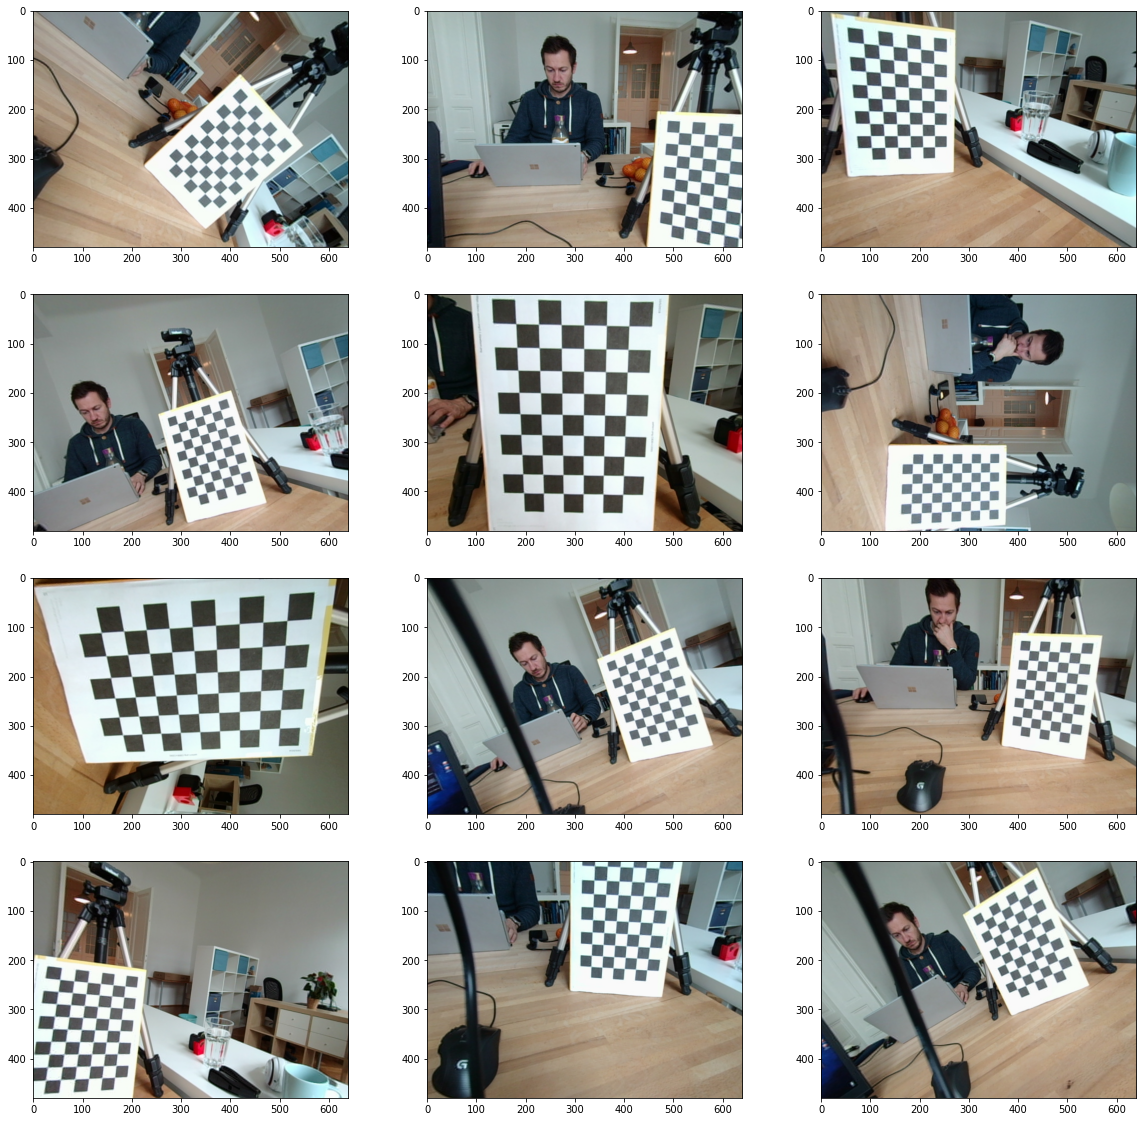

Done


In [ ]:
# undistort the image with the calibration
plt.figure(figsize=figsize)
for i,fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)

    if i<12:
        plt.subplot(4,3,i+1)
        plt.imshow(dst)

plt.show()
print('Done')



**2- Pose Estimation**
Calibration describes the characteristics of our cameras that are usable by our program, that is; the camera matrix and distortion coefficients. From this information we can take a picture of a patterned image with our camera and calculate how that object is situated in real world space. For an example; we will use the chessboard image and visualize the planar objects relative position by drawing a 3D cube aligned to its orientation.


## Example for full projection from 3D to 2D of a cube


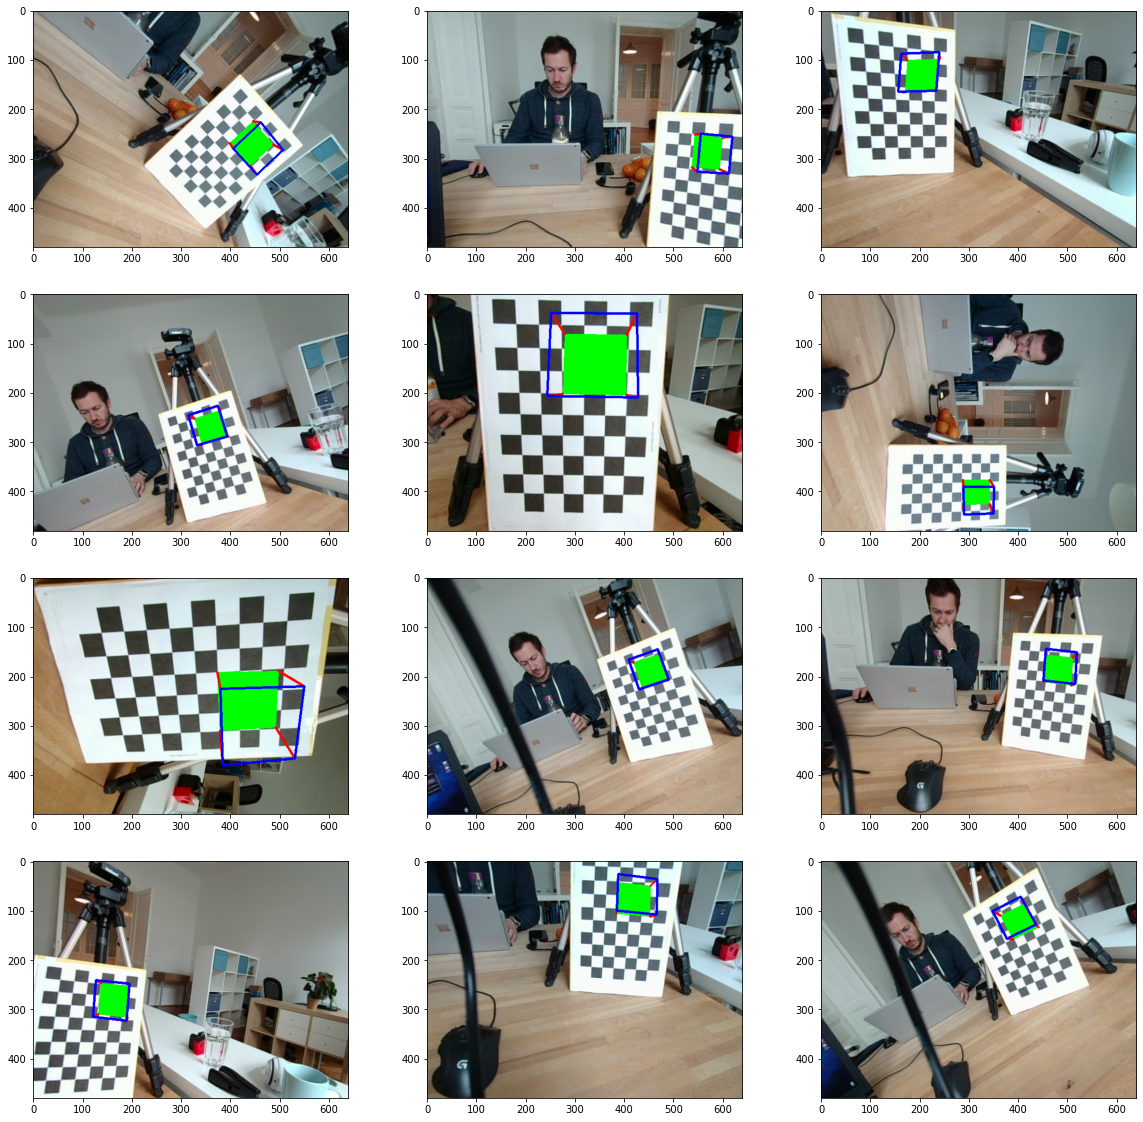

In [ ]:
# Cube vertices coordinates
objectPoints = 3*square_size*np.array([[0,0,0], [0,1,0], [1,1,0], [1,0,0],[0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]])

def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-1)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img

plt.figure(figsize=figsize)
for i,fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    
    imgpts = cv2.projectPoints(	objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = draw(dst, imgpts)
    

    if i<12:
        plt.subplot(4,3,i+1)
        plt.imshow(drawn_image)

plt.show()


**Question 1-** First, modify the cude draw function in order to draw an X, Y, Z axis onto our image, positioned at the chessboard’s bottom corner. The axis points from points in 3D space are projected to points on the 2D image plane. When the axis is identified we can then use the draw function to visualize its orientation. Second, modify the cube with other object (cylinder, sphere, cone, ...)

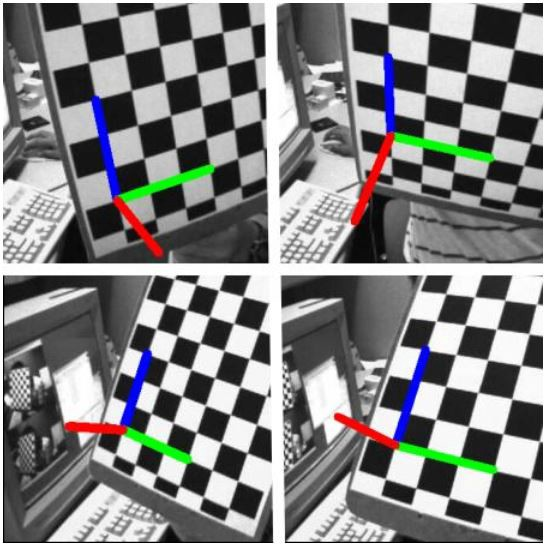

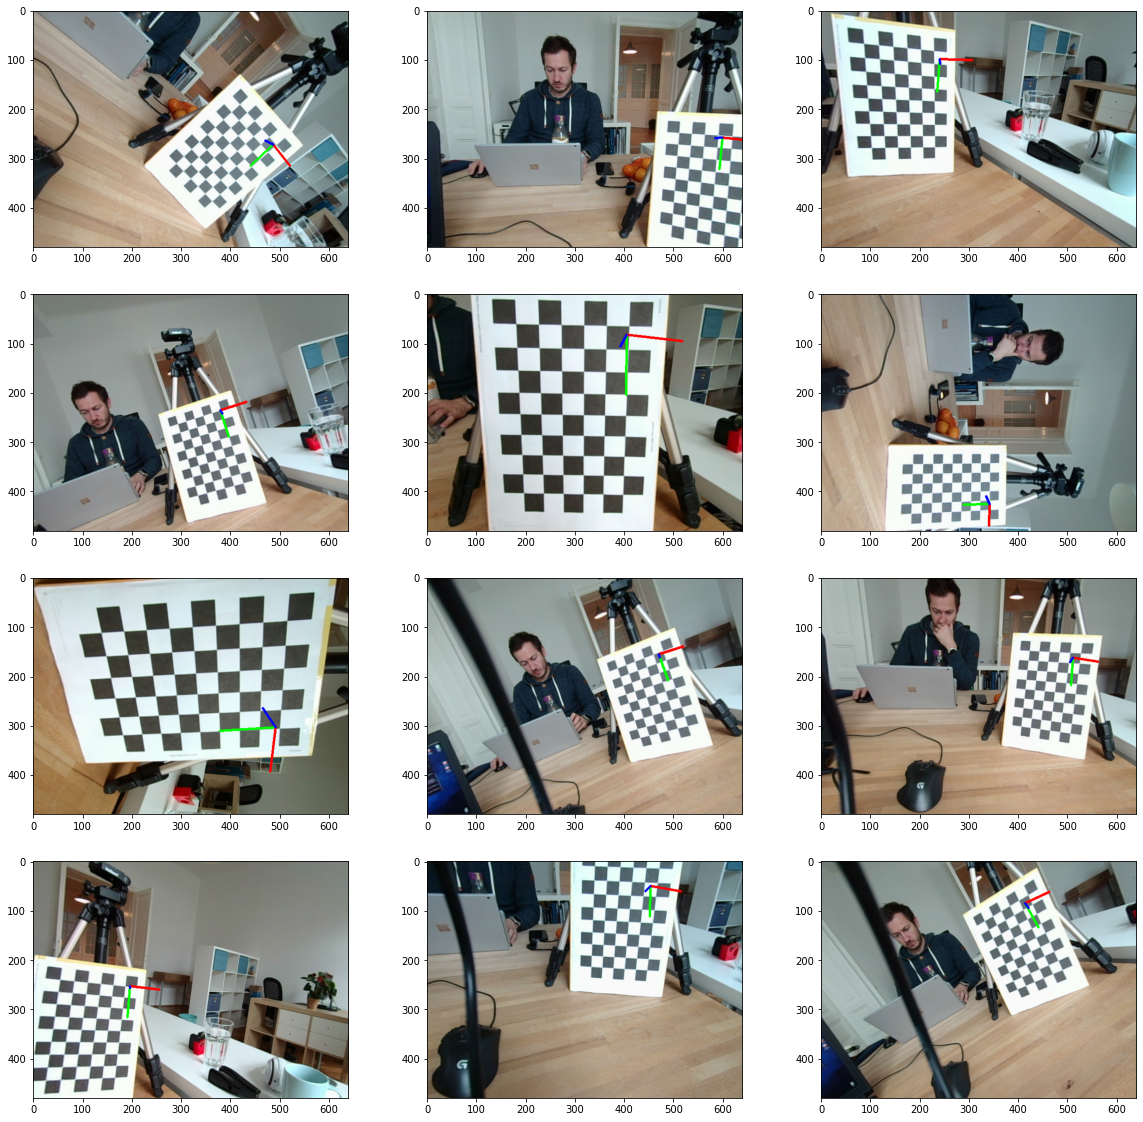

In [ ]:
# 3D Axis vertices coordinates
objectPoints = 3*square_size*np.array([[0,0,0],[1,0,0],[0,-1,0],[0,0,1]])

def drawAxis(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    cv2.line(img, tuple(imgpts[0]), tuple(imgpts[1]), (0,255,0), 3) # X axis (green)
    cv2.line(img, tuple(imgpts[0]), tuple(imgpts[2]), (255,0,0), 3) # Y axis (red)
    cv2.line(img, tuple(imgpts[0]), tuple(imgpts[3]), (0,0,255), 3) # Z axis (blue)

    return img

plt.figure(figsize=figsize)
for i,fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    
    imgpts = cv2.projectPoints(	objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = drawAxis(dst, imgpts)
    

    if i<12:
        plt.subplot(4,3,i+1)
        plt.imshow(drawn_image)

plt.show()

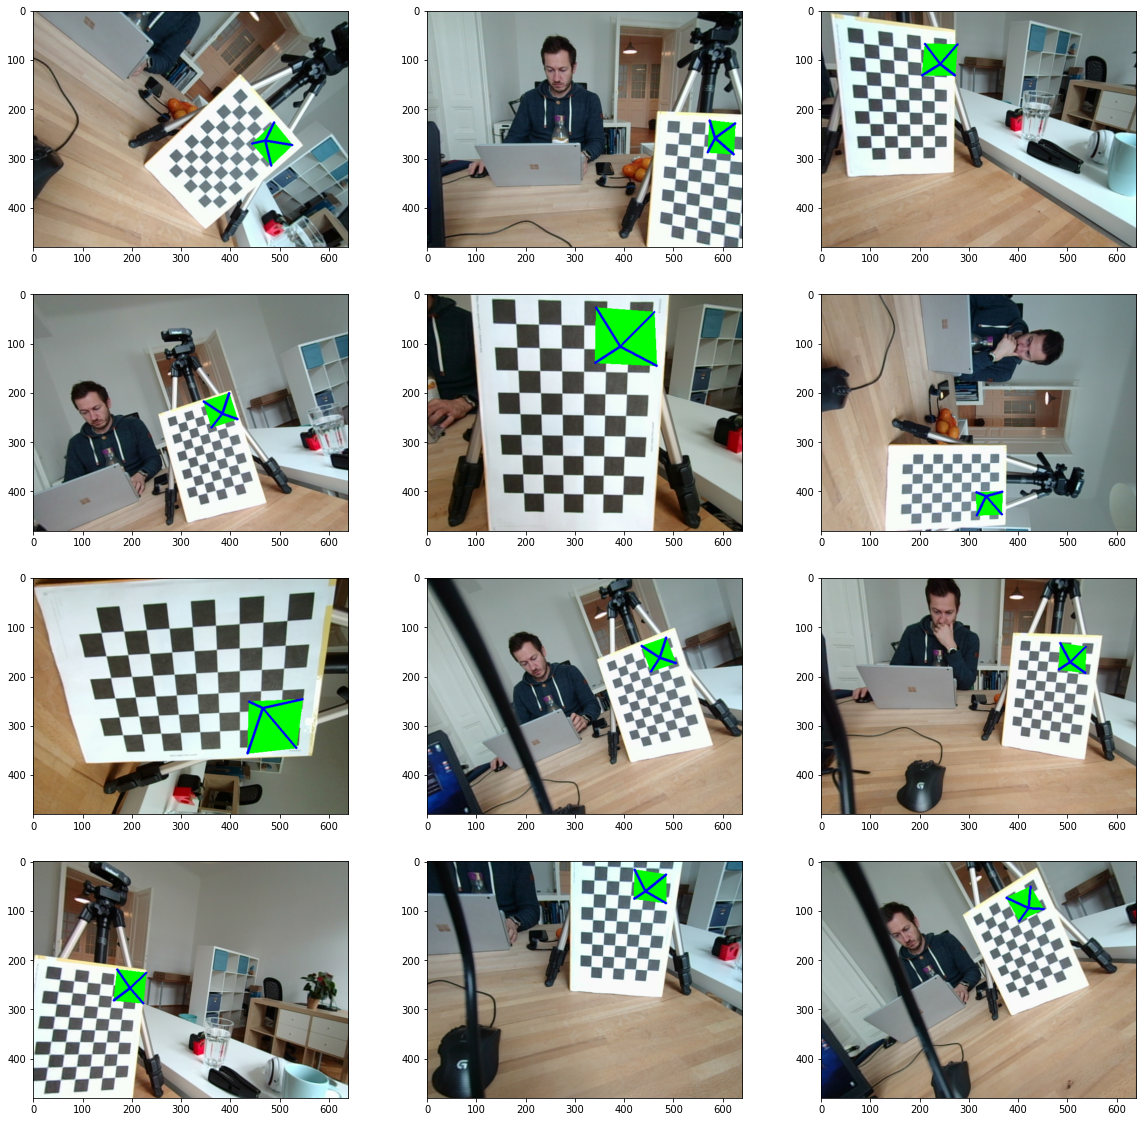

In [ ]:
# Pyramid vertices coordinates
#objectPoints = 3*square_size*np.array([[0.5,0,0.5],[0.5,0,-0.5],[-0.5,0,-0.5],[-0.5,0,0.5],[0,1,0]])
objectPoints = 3*square_size*np.array([[0.5,0.5,0], [0.5,-0.5,0], [-0.5,-0.5,0], [-0.5,0.5,0], [0,0,1]])

def drawPyramid(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw square base
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-1)

    # draw pillars
    for i in range(4):
      cv2.line(img, tuple(imgpts[4]), tuple(imgpts[i]), (0,0,255), 3)

    return img

plt.figure(figsize=figsize)
for i,fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    
    imgpts = cv2.projectPoints(	objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = drawPyramid(dst, imgpts)
    

    if i<12:
        plt.subplot(4,3,i+1)
        plt.imshow(drawn_image)

plt.show()

# **3- Multiview Geometry**

Epipolar geometry can be explained by the fact that the image information is presented on a 2D plane where the distance of each point (or pixel) away form the camera lens is simply non-existent. But this is precisely the information we need in order to perform 3D reconstruction with 2D images. The key to our solution lies in using a second camera to take a picture of the same object and compare each image to extract depth information. Interesting to note is that our eyes act in a similar war to perform this very same task. 

The objective of this exercice is to covered the basics of epipolar geometry addressed in class, that are needed in order to find the epipole and epiline, that is; the fundamental and essentials matrices.
The figure below illustrates some basic concepts of multi-view geometry in a scenario with two cameras taking a picture of the same scene.

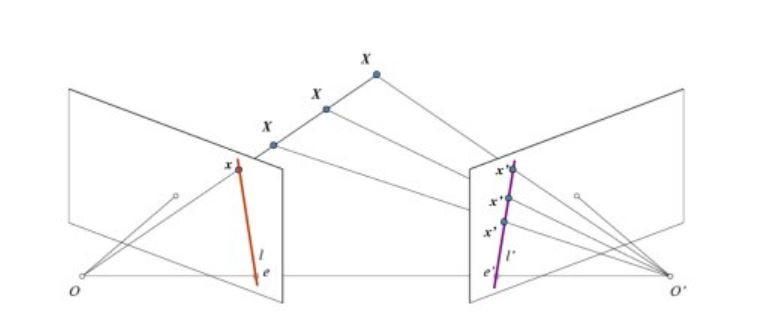

The essential matrix contains information about translation and rotation which describes the camera’s position relative to its counterpart. The Essential Matrix is illustrated below for a better understanding.

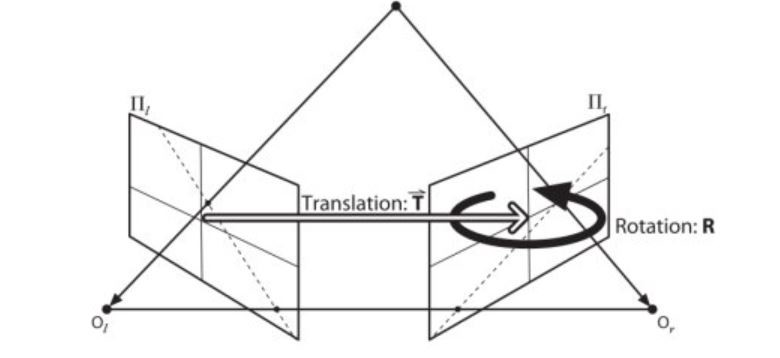

**3.1- Epipolar geometry:**

If we have the possibility to calibrate the camera, we can use the essential matrix, where the information is derived from the real world positioning of our cameras. Otherwise, the fundamental matrix will have to be calculated ourselves. The fundamental matrix contains the same information as the essential matrix but also includes intrinsic information about both cameras so that we can relate the two in such terms.
While the information found in the essential matrix is derived from the real world positioning of our cameras, the fundamental matrix will have to be calculated ourselves. What the fundamental matrix allows us to do is map a single point in one image to its corresponding epiline in the other giving us a starting point to later find the epipole line between the two cameras center points and the epipolar plane.
We can use OpenCV to derive the matrix from a set of known matching points in each image. To do this we analyze both images and extract their best matching pixel coordinates. In the code below we extract these points using SIFT descriptors and FLANN based matcher and ratio text.

In [ ]:
!wget https://github.com/kinect59/3DET20/tree/master/Data/potato-head-left.png
!wget https://github.com/kinect59/3DET20/tree/master/Data/potato-head-right.png

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('./potato-head-left.png', cv2.IMREAD_GRAYSCALE)  #queryimage # left image
img2 = cv2.imread('./potato-head-right.png', cv2.IMREAD_GRAYSCALE) #trainimage # right image

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

The obtained list of the best pixel matches in both images will then be used to calculate the fundamental matrix.

In [ ]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

Draw lines over images which will later be used to visualize the epilines.

In [ ]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Now we can proceed to calculate the epilines which correspond to points in the opposing image. The objective is to display two images with epilines representing an array of points from the opposite image.

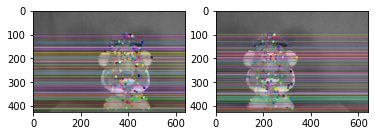

In [ ]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

Reproduce results on other images (the two shots are much wider than a set of human eyes would be) to illustrate Epipolar Geometry


In [ ]:
!wget https://github.com/kinect59/3DET20/tree/master/Data/dvd_left.jpg
!wget https://github.com/kinect59/3DET20/tree/master/Data/dvd_right.jpg

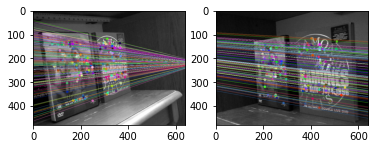

In [ ]:
#Séb
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('./dvd_left.jpg', cv2.IMREAD_GRAYSCALE)  #queryimage # left image
img2 = cv2.imread('./dvd_right.jpg', cv2.IMREAD_GRAYSCALE) #trainimage # right image

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

We can acknowledge how important camera resolution comes into play when attempting to perform 3D reconstruction. Indded, to produce an accurate fundamental matrix, we must identifying closely matching pixels in each image.

**3.2- Depth Map** 

The objective here is to visualize the depth of objects found in a set of stereo images. In other words, we will produce a gray scale heat map whereby lighter shades of gray will signify objects close to the camera lens with progressively darker shades to distinguish objects further away. The depth of a point in real world space can be calculated through the use of mathematical formulas and functions that incorporate the principles of epipolar geometry. The image below illustrates a proof of these concepts in action. The idea here is that the equivalent triangles as denoted Ofx and O’fx’ can be compared to each other in order to extract the depth Z of point X. The equation that allows us to accomplish this is shown below.

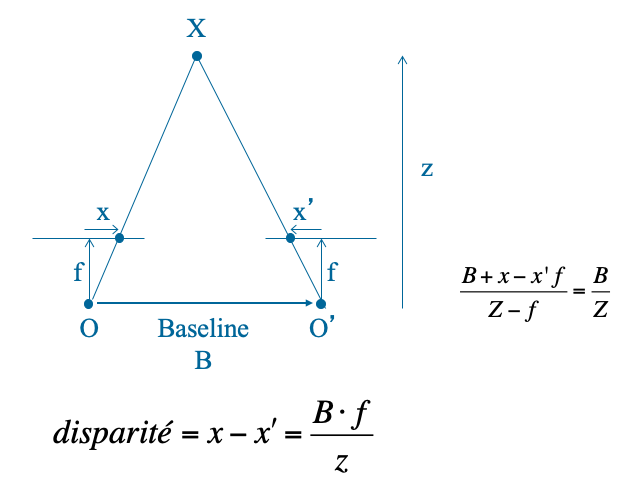

Open CV is being used to find matched points in each of our images, greatly aided and expedited by the principles of an epipolar constraint. Subsequently it proceeds to calculate the disparity between the matched points therefore giving us the depth of the object in question. This process can be repeated for every pixel in our stereo images offering our concluding solution to 3D reconstruction.
Below we can see the code which calculate disparity values between the images by calling the compute method of a stereo object from the state-of-the-art.

In [ ]:
def depth_map(imgL, imgR):
    """ Depth map calculation. Works with SGBM and WLS. Need rectified images, returns depth map ( left to right disparity ) """
    # SGBM Parameters -----------------
    window_size = 3  # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

    left_matcher = cv2.StereoSGBM_create(
        minDisparity=-1,
        numDisparities=5*16,  # max_disp has to be dividable by 16 f. E. HH 192, 256
        blockSize=window_size,
        P1=8 * 3 * window_size,
        # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
        P2=32 * 3 * window_size,
        disp12MaxDiff=12,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    # FILTER Parameters
    lmbda = 80000
    sigma = 1.3
    visual_multiplier = 6

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)

    wls_filter.setSigmaColor(sigma)
    displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!

    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)

    return filteredImg
    

You need just to call depth_map fonction.

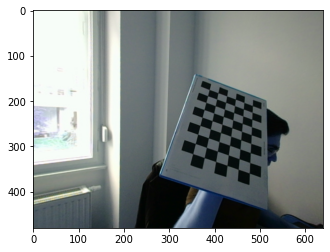

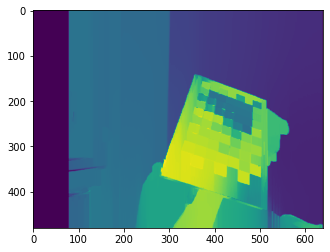

In [ ]:
left_image = cv2.imread('./bothImagesFixedStereo/left21.png')
right_image = cv2.imread('./bothImagesFixedStereo/right21.png')

left_rectified = cv2.undistort(left_image, camera_matrix, dist_coefs)
right_rectified = cv2.undistort(right_image, camera_matrix, dist_coefs)
# We need grayscale for disparity map.
gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)


disp = depth_map(gray_left, gray_right)
plt.imshow(left_rectified)
plt.show() 
plt.imshow(disp)
plt.show() 


**Question:** Apply the reconstruction on potato-head images (guess the focal legth and camera distance)

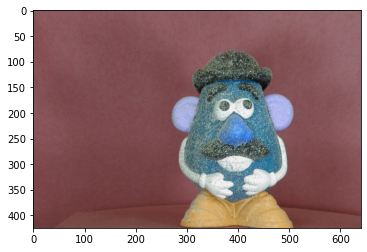

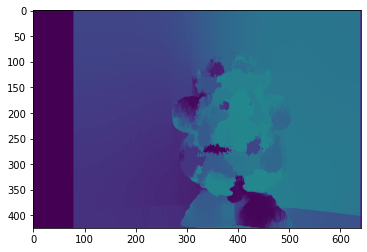

In [ ]:
left_image = cv2.imread('./potato-head-left.png')
right_image = cv2.imread('./potato-head-right.png')

left_rectified = cv2.undistort(left_image, camera_matrix, dist_coefs)
right_rectified = cv2.undistort(right_image, camera_matrix, dist_coefs)
# We need grayscale for disparity map.
gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)


disp = depth_map(gray_left, gray_right)
plt.imshow(left_rectified)
plt.show() 
plt.imshow(disp)
plt.show()

**3.3- 3D points from depth map:** 

Once we have the disparity map calculated we have to get an array of the colors used in the image. Since we downsampled the image we need to get the height and width.
More importantly we need to get the transformation matrix. This matrix is the one responsible to reproject the depth and colors into 3D space. Open CV’s documentation has an example of a transformation matrix.

To map the depth pixels with color pixels, first you need to undistort rgb and depth images using the estimated distortion coefficients. Then, using the depth camera intrinsics, each pixel (x_d,y_d) of the depth camera can be projected to metric 3D space using the following formula:

*   P3D.x = (x_d - cx_d) * depth(x_d,y_d) / fx_d
*   P3D.y = (y_d - cy_d) * depth(x_d,y_d) / fy_d
*   P3D.z = depth(x_d,y_d)
with fx_d, fy_d, cx_d and cy_d the intrinsics of the depth camera.

We can then reproject each 3D point on the color image and get its color:

*   P3D' = R.P3D + T 
*   P2D_rgb.x = (P3D'.x * fx_rgb / P3D'.z) + cx_rgb
*   P2D_rgb.y = (P3D'.y * fy_rgb / P3D'.z) + cy_rgb

with R and T the rotation and translation parameters estimated during the stereo calibration.


In [ ]:
import cv2
import numpy as np

def remove_invalid(disp_arr, points, colors):
    mask = (
        (disp_arr > disp_arr.min()) &
        np.all(~np.isnan(points), axis=1) &
        np.all(~np.isinf(points), axis=1)
    )
    return points[mask], colors[mask]

def calc_point_cloud(image, disp, q):
    points = cv2.reprojectImageTo3D(disp, q).reshape(-1, 3)
    colors = image.reshape(-1, 3)
    return remove_invalid(disp.reshape(-1), points, colors)


def project_points(points, colors, r, t, k, dist_coefs, width, height):
    projected, _ = cv2.projectPoints(points, r, t, k, dist_coeff)
    xy = projected.reshape(-1, 2).astype(np.int)
    mask = (
        (0 <= xy[:, 0]) & (xy[:, 0] < width) &
        (0 <= xy[:, 1]) & (xy[:, 1] < height)
    )
    return xy[mask], colors[mask]


def calc_projected_image(points, colors, r, t, k, dist_coeff, width, height):
    xy, cm = project_points(points, colors, r, t, k, dist_coeff, width, height)
    image = np.zeros((height, width, 3), dtype=colors.dtype)
    image[xy[:, 1], xy[:, 0]] = cm
    return image


def rotate(arr, anglex, anglez):
    return np.array([  # rx
        [1, 0, 0],
        [0, np.cos(anglex), -np.sin(anglex)],
        [0, np.sin(anglex), np.cos(anglex)]
    ]).dot(np.array([  # rz
        [np.cos(anglez), 0, np.sin(anglez)],
        [0, 1, 0],
        [-np.sin(anglez), 0, np.cos(anglez)]
    ])).dot(arr)

For the example bellew, we consider a disatnce between the cameras 0.06 m and the focal length extracted from the calibration matrix 414.6.

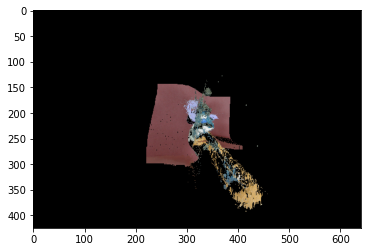

"\nangles = {  # x, z\n    'w': (-np.pi/6, 0),\n    's': (np.pi/6, 0),\n    'a': (0, np.pi/6),\n    'd': (0, -np.pi/6)\n}\n\nwhile 1:\n    key = cv2.waitKey(0)\n\n    if key not in range(256):\n        continue\n\n    ch = chr(key)\n    if ch in angles:\n        ax, az = angles[ch]\n        r = rotate(r, -ax, -az)\n        t = rotate(t, ax, az)\n        view(r, t)\n\n    elif ch == '\x1b':  # esc\n        cv2.destroyAllWindows()\n        break\n      "

In [ ]:
tx = 6
focal_length= 414.6

height, width, _ = left_rectified.shape
q = np.array([
    [1, 0, 0, -width/2],
    [0, 1, 0, -height/2],
    [0, 0, 0, focal_length],
    [0, 0, -1/tx, 0]
])
points, colors = calc_point_cloud(left_rectified, disp, q)

r = np.eye(3)
t = np.array([0, 0, -100.0])
k = np.array([
    [focal_length, 0, width/2],
    [0, focal_length, height/2],
    [0, 0, 1]
])
dist_coeff = np.zeros((4, 1))

def view(r, t):
  proj_image = calc_projected_image(points, colors, r, t, k, dist_coeff, width, height)
  plt.imshow(proj_image)
  plt.show() 

view(r, t)
'''
angles = {  # x, z
    'w': (-np.pi/6, 0),
    's': (np.pi/6, 0),
    'a': (0, np.pi/6),
    'd': (0, -np.pi/6)
}

while 1:
    key = cv2.waitKey(0)

    if key not in range(256):
        continue

    ch = chr(key)
    if ch in angles:
        ax, az = angles[ch]
        r = rotate(r, -ax, -az)
        t = rotate(t, ax, az)
        view(r, t)

    elif ch == '\x1b':  # esc
        cv2.destroyAllWindows()
        break
      '''

We can export the point cloud file into .ply format (you can download the free software [MeshLab](https://www.meshlab.net/#download) to visualise it.

In [ ]:
#Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [ ]:
#Generate  point cloud. 
print ("\nGenerating the 3D map...")
#Get new downsampled width and height 
h, w, _ = left_rectified.shape
#Load focal length. 
focal_length = 4.146
#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
Q = np.float32([[1,0,0,-w/2.0],
    [0,-1,0,h/2.0],
    [0,0,0,-focal_length],
    [0,0,1,0]])
#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q2 = np.float32([[1,0,0,0],
    [0,-1,0,0],
    [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
    [0,0,0,1]])
#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disp, Q2)
#Get color points
colors = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB)
#Get rid of points with value 0 (i.e no depth)
mask_map = disp > disp.min()
#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]
#Define name for output file
output_file = 'reconstructed.ply'
#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)


Generating the 3D map...

 Creating the output file... 

